In [1]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.pulse import library as pulse_lib
from qiskit import assemble
from qiskit.tools.monitor import job_monitor
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Owner\anaconda3\lib\site-packages\qiskit\quantum_info\operators\pauli.py:107: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.zeros(len(label), dtype=np.bool)
C:\Users\Owner\anaconda3\lib\site-packages\qiskit\quantum_info\operators\pauli.py:108: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros(len(label), dtype=np.bool)
C:\U

In [26]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')


C:\Users\Owner\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-06-28 15:39:42,444: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [4]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [5]:
backend_defaults = backend.defaults()

In [6]:
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0

center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

Qubit 0 has an estimated frequency of 4.971662468381202 GHz.


In [7]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [8]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [9]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [10]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [11]:
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating 

print('The length of the gaussian pulse is',drive_samples)

The length of the gaussian pulse is 2704


In [12]:
def plot_shot_results(job):
    from matplotlib import pyplot as plt
    y_pulse_results = job.result(timeout=120)
    measure_list = y_pulse_results.get_counts()
    zero_list = []
    sum_list = []
    print(measure_list)
    for prob in measure_list:
        s = 0.
        for x in prob:
            s+=prob[x]
        sum_list.append(s)
        try:
            zero_list.append(prob['1'])
        except:
            zero_list.append(0)
    print(zero_list)
    plt.plot(sum_list)
    plt.plot(zero_list, '.')
    plt.show()

In [13]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

# 1. Define Gaussian Clifford Gates

In [14]:
pi_amp = 0.1338881278135786
x_pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='x_pi_pulse')
x_halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp/2, 
                              sigma=drive_sigma,
                              name='x_halfpi_pulse')
minus_x_halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=3*pi_amp/2, 
                              sigma=drive_sigma,
                              name='x_minus_halfpi_pulse')
y_pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp *1j, 
                              sigma=drive_sigma,
                              name='y_pi_pulse')
y_halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp/2*1j, 
                              sigma=drive_sigma,
                              name='y_halfpi_pulse')
minus_y_halfpi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=3*pi_amp/2*1j, 
                              sigma=drive_sigma,
                              name='y_minus_halfpi_pulse')

## Our gaussian clifford gates !

In [15]:
x_pulse = pulse.Waveform(x_pi_pulse.samples, name = 'x')
y_pulse = pulse.Waveform(y_pi_pulse.samples, name = 'y')
z_pulse_samples = np.concatenate((x_pi_pulse.samples, y_pi_pulse.samples))
z_pulse = pulse.Waveform(z_pulse_samples, name = 'z')
s_pulse_samples = np.concatenate((y_halfpi_pulse.samples,x_halfpi_pulse.samples, minus_y_halfpi_pulse.samples))
s_pulse = pulse.Waveform(s_pulse_samples, name = 's')
xs_pulse_samples = np.concatenate((minus_x_halfpi_pulse.samples,y_halfpi_pulse.samples, minus_x_halfpi_pulse.samples))
xs_pulse = pulse.Waveform(xs_pulse_samples, name = 'xs')
ys_pulse_samples = np.concatenate((minus_y_halfpi_pulse.samples,minus_x_halfpi_pulse.samples, minus_y_halfpi_pulse.samples))
ys_pulse = pulse.Waveform(ys_pulse_samples, name = 'ys')
zs_pulse_samples = np.concatenate((y_halfpi_pulse.samples, minus_x_halfpi_pulse.samples, minus_y_halfpi_pulse.samples))
zs_pulse = pulse.Waveform(zs_pulse_samples, name = 'zs')
h_pulse = pulse.Waveform(np.concatenate((y_halfpi_pulse.samples, x_pi_pulse.samples)), name = 'h')
xh_pulse = pulse.Waveform(y_halfpi_pulse.samples, name = 'xh')
yh_pulse = pulse.Waveform(np.concatenate((x_pi_pulse.samples, y_halfpi_pulse.samples)), name = 'yh')
zh_pulse = pulse.Waveform(minus_y_halfpi_pulse.samples, name = 'zh')
sh_pulse = pulse.Waveform(np.concatenate((minus_x_halfpi_pulse.samples, minus_y_halfpi_pulse.samples)), name = 'sh')
xsh_pulse_samples = np.concatenate((minus_x_halfpi_pulse.samples,minus_y_halfpi_pulse.samples, x_pi_pulse.samples))
xsh_pulse = pulse.Waveform(xsh_pulse_samples, name = 'xsh')
ysh_pulse = pulse.Waveform(np.concatenate((minus_x_halfpi_pulse.samples, y_halfpi_pulse.samples)), name = 'ysh')
zsh_pulse_samples = np.concatenate((minus_x_halfpi_pulse.samples, y_halfpi_pulse.samples, x_pi_pulse.samples))
zsh_pulse = pulse.Waveform(zsh_pulse_samples, name = 'zsh')
hs_pulse = pulse.Waveform(np.concatenate((y_halfpi_pulse.samples, minus_x_halfpi_pulse.samples)), name = 'hs')
xhs_pulse = pulse.Waveform(np.concatenate((y_halfpi_pulse.samples, x_halfpi_pulse.samples)), name = 'xhs')
yhs_pulse_samples = np.concatenate((y_halfpi_pulse.samples, minus_x_halfpi_pulse.samples, y_pi_pulse.samples))
yhs_pulse = pulse.Waveform(yhs_pulse_samples, name = 'yhs')
zhs_pulse_samples =  np.concatenate((y_halfpi_pulse.samples, x_halfpi_pulse.samples, y_pi_pulse.samples))
zhs_pulse = pulse.Waveform(zhs_pulse_samples, name= 'zhs')
shs_pulse = pulse.Waveform(minus_x_halfpi_pulse.samples, name= 'shs')
xshs_pulse = pulse.Waveform(x_halfpi_pulse.samples, name= 'xshs')
yshs_pulse = pulse.Waveform(np.concatenate((minus_x_halfpi_pulse.samples, y_pi_pulse.samples)), name = 'yshs')
zshs_pulse = pulse.Waveform(np.concatenate((x_halfpi_pulse.samples, y_pi_pulse.samples)), name = 'zshs')

In [16]:
gaussian_clifford_gates = [
0,\
x_pulse,\
y_pulse,\
z_pulse,\
s_pulse,\
xs_pulse,\
ys_pulse,\
zs_pulse,\
h_pulse,\
xh_pulse,\
yh_pulse,\
zh_pulse,\
sh_pulse,\
xsh_pulse,\
ysh_pulse,\
zsh_pulse,\
hs_pulse,\
xhs_pulse,\
yhs_pulse,\
zhs_pulse,\
shs_pulse,\
xshs_pulse,\
yshs_pulse,\
zshs_pulse,\
]


# 2. Define SOC Clifford Gates

In [17]:
convert_factor = 1.64694154415136e-08,
omega = np.pi/(drive_samples_us*1e-6)
#delete below code

amplitude_pi_X_x = np.loadtxt("amplitude_pi_X_x.csv", delimiter = ',') * convert_factor
amplitude_pi_X_y = np.loadtxt("amplitude_pi_X_y.csv", delimiter = ',') * convert_factor
Signal = np.zeros(drive_samples, np.complex128)


for i in range(len(amplitude_pi_X_x)):
    Signal += amplitude_pi_X_x[i] * np.sin(omega * dt * np.arange(drive_samples) * (i+1))
    Signal += amplitude_pi_X_y[i] * np.sin(omega * dt * np.arange(drive_samples) * (i+1)) * 1j
print(max(Signal))

(0.25230838251875964-0.004076602062011545j)


In [18]:
amplitude_multiplier = 1
SOC_x_pi_pulse = pulse.Waveform(Signal*amplitude_multiplier, name = 'SOC_x_pi_pulse')
SOC_y_pi_pulse = pulse.Waveform(Signal*amplitude_multiplier*1j, name = 'SOC_y_pi_pulse')

In [19]:
convert_factor = 1.64694154415136e-08
omega = np.pi/(drive_samples_us*1e-6)
#delete below code

amplitude_pi_over_2_X_x = np.loadtxt("amplitude_pi_over_2_X_x.csv", delimiter = ',') * convert_factor
amplitude_pi_over_2_X_y = np.loadtxt("amplitude_pi_over_2_X_y.csv", delimiter = ',') * convert_factor
Signal = np.zeros(drive_samples, np.complex128)


for i in range(len(amplitude_pi_over_2_X_x)):
    Signal += amplitude_pi_over_2_X_x[i] * np.sin(omega * dt * np.arange(drive_samples) * (i+1))
    Signal += amplitude_pi_over_2_X_y[i] * np.sin(omega * dt * np.arange(drive_samples) * (i+1)) * 1j

In [20]:
amplitude_multiplier = 1
SOC_x_halfpi_pulse = pulse.Waveform(Signal*amplitude_multiplier, name = 'SOC_x_halfpi_pulse')
SOC_minus_x_halfpi_pulse = pulse.Waveform(-Signal*amplitude_multiplier, name = 'SOC_x_halfpi_pulse')
SOC_y_halfpi_pulse = pulse.Waveform(Signal*amplitude_multiplier*1j, name = 'SOC_y_halfpi_pulse')
SOC_minus_y_halfpi_pulse = pulse.Waveform(-Signal*amplitude_multiplier*1j, name = 'SOC_y_halfpi_pulse')

## OUR SOC Clifford Gates!

In [21]:
SOC_x_pulse = pulse.Waveform(SOC_x_pi_pulse.samples, name = 'SOC_x')
SOC_y_pulse = pulse.Waveform(SOC_y_pi_pulse.samples, name = 'SOC_y')
SOC_z_pulse_samples = np.concatenate((SOC_x_pi_pulse.samples, SOC_y_pi_pulse.samples))
SOC_z_pulse = pulse.Waveform(SOC_z_pulse_samples, name = 'SOC_z')
SOC_s_pulse_samples = np.concatenate((SOC_y_halfpi_pulse.samples,SOC_x_halfpi_pulse.samples, SOC_minus_y_halfpi_pulse.samples))
SOC_s_pulse = pulse.Waveform(SOC_s_pulse_samples, name = 'SOC_s')
SOC_xs_pulse_samples = np.concatenate((SOC_minus_x_halfpi_pulse.samples, SOC_y_halfpi_pulse.samples, SOC_minus_x_halfpi_pulse.samples))
SOC_xs_pulse = pulse.Waveform(SOC_xs_pulse_samples, name = 'SOC_xs')
SOC_ys_pulse_samples = np.concatenate((SOC_minus_y_halfpi_pulse.samples,SOC_minus_x_halfpi_pulse.samples, SOC_minus_y_halfpi_pulse.samples))
SOC_ys_pulse = pulse.Waveform(SOC_ys_pulse_samples, name = 'SOC_ys')
SOC_zs_pulse_samples = np.concatenate((SOC_y_halfpi_pulse.samples, SOC_minus_x_halfpi_pulse.samples, SOC_minus_y_halfpi_pulse.samples))
SOC_zs_pulse = pulse.Waveform(SOC_zs_pulse_samples, name = 'SOC_zs')
SOC_h_pulse_samples = np.concatenate((SOC_y_halfpi_pulse.samples, SOC_x_pi_pulse.samples))
SOC_h_pulse = pulse.Waveform(SOC_h_pulse_samples, name = 'SOC_h')
SOC_xh_pulse = pulse.Waveform(SOC_y_halfpi_pulse.samples, name = 'SOC_xh')
SOC_yh_pulse = pulse.Waveform(np.concatenate((SOC_x_pi_pulse.samples, SOC_y_halfpi_pulse.samples)), name = 'SOC_yh')
SOC_zh_pulse = pulse.Waveform(SOC_minus_y_halfpi_pulse.samples, name = 'SOC_zh')
SOC_sh_pulse = pulse.Waveform(np.concatenate((SOC_minus_x_halfpi_pulse.samples, SOC_minus_y_halfpi_pulse.samples)), name = 'SOC_sh')
SOC_xsh_pulse_samples = np.concatenate((SOC_minus_x_halfpi_pulse.samples,SOC_minus_y_halfpi_pulse.samples, SOC_x_pi_pulse.samples))
SOC_xsh_pulse = pulse.Waveform(SOC_xsh_pulse_samples, name = 'xsh')
SOC_ysh_pulse = pulse.Waveform(np.concatenate((SOC_minus_x_halfpi_pulse.samples, SOC_y_halfpi_pulse.samples)), name = 'SOC_ysh')
SOC_zsh_pulse_samples = np.concatenate((SOC_minus_x_halfpi_pulse.samples, SOC_y_halfpi_pulse.samples, SOC_x_pi_pulse.samples))
SOC_zsh_pulse = pulse.Waveform(SOC_zsh_pulse_samples, name = 'SOC_zsh')
SOC_hs_pulse = pulse.Waveform(np.concatenate((SOC_y_halfpi_pulse.samples, SOC_minus_x_halfpi_pulse.samples)), name = 'SOC_hs')
SOC_xhs_pulse = pulse.Waveform(np.concatenate((SOC_y_halfpi_pulse.samples, SOC_x_halfpi_pulse.samples)), name = 'SOC_xhs')
SOC_yhs_pulse_samples = np.concatenate((SOC_y_halfpi_pulse.samples, SOC_minus_x_halfpi_pulse.samples, SOC_y_pi_pulse.samples))
SOC_yhs_pulse = pulse.Waveform(SOC_yhs_pulse_samples, name = 'SOC_yhs')
SOC_zhs_pulse_samples =  np.concatenate((SOC_y_halfpi_pulse.samples, SOC_x_halfpi_pulse.samples, SOC_y_pi_pulse.samples))
SOC_zhs_pulse = pulse.Waveform(SOC_zhs_pulse_samples, name= 'SOC_zhs')
SOC_shs_pulse = pulse.Waveform(SOC_minus_x_halfpi_pulse.samples, name= 'SOC_shs')
SOC_xshs_pulse = pulse.Waveform(SOC_x_halfpi_pulse.samples, name= 'SOC_xshs')
SOC_yshs_pulse = pulse.Waveform(np.concatenate((SOC_minus_x_halfpi_pulse.samples, SOC_y_pi_pulse.samples)), name = 'SOC_yshs')
SOC_zshs_pulse = pulse.Waveform(np.concatenate((SOC_x_halfpi_pulse.samples, SOC_y_pi_pulse.samples)), name = 'SOC_zshs')

In [22]:
SOC_clifford_gates = [
0,\
SOC_x_pulse,\
SOC_y_pulse,\
SOC_z_pulse,\
SOC_s_pulse,\
SOC_xs_pulse,\
SOC_ys_pulse,\
SOC_zs_pulse,\
SOC_h_pulse,\
SOC_xh_pulse,\
SOC_yh_pulse,\
SOC_zh_pulse,\
SOC_sh_pulse,\
SOC_xsh_pulse,\
SOC_ysh_pulse,\
SOC_zsh_pulse,\
SOC_hs_pulse,\
SOC_xhs_pulse,\
SOC_yhs_pulse,\
SOC_zhs_pulse,\
SOC_shs_pulse,\
SOC_xshs_pulse,\
SOC_yshs_pulse,\
SOC_zshs_pulse,\
]


## 3. Define Qiskit default Clifford gate (In the schedule form)

In [72]:
from qiskit import QuantumCircuit
from qiskit import transpile, schedule as build_schedule
from qiskit.circuit.library import UGate
%matplotlib inline
x_circ = QuantumCircuit(1, 1)
x_circ.x(0)
x_circ = transpile(x_circ, backend)
x_schedule = build_schedule(x_circ, backend)

y_circ = QuantumCircuit(1, 1)
y_circ.y(0)
y_circ = transpile(y_circ, backend)
y_schedule = build_schedule(y_circ, backend)

z_circ = QuantumCircuit(1, 1)
z_circ.z(0)
z_circ = transpile(z_circ, backend)
z_schedule = build_schedule(z_circ, backend)

s_circ = QuantumCircuit(1, 1)
s_circ.s(0)
s_circ = transpile(s_circ, backend)
s_schedule = build_schedule(s_circ, backend)


xs_circ = QuantumCircuit(1, 1)
xs_circ.s(0)
xs_circ.x(0)
xs_circ = transpile(xs_circ, backend)
xs_schedule = build_schedule(xs_circ, backend)

ys_circ = QuantumCircuit(1, 1)
ys_circ.s(0)
ys_circ.y(0)
ys_circ = transpile(ys_circ, backend)
ys_schedule = build_schedule(ys_circ, backend)

zs_circ = QuantumCircuit(1, 1)
zs_circ.s(0)
zs_circ.z(0)
zs_circ = transpile(zs_circ, backend)
zs_schedule = build_schedule(zs_circ, backend)

h_circ = QuantumCircuit(1, 1)
h_circ.h(0)
backend = backend
h_circ = transpile(h_circ, backend)
h_schedule = build_schedule(h_circ, backend)

xh_circ = QuantumCircuit(1, 1)
xh_circ.h(0)
xh_circ.x(0)
backend = backend
xh_circ = transpile(xh_circ, backend)
xh_schedule = build_schedule(xh_circ, backend)

yh_circ = QuantumCircuit(1, 1)
yh_circ.h(0)
yh_circ.y(0)
yh_circ = transpile(yh_circ, backend)
yh_schedule = build_schedule(yh_circ, backend)

zh_circ = QuantumCircuit(1, 1)
zh_circ.h(0)
zh_circ.z(0)
zh_circ = transpile(zh_circ, backend)
zh_schedule = build_schedule(zh_circ, backend)

sh_circ = QuantumCircuit(1, 1)
sh_circ.h(0)
sh_circ.s(0)
sh_circ = transpile(sh_circ, backend)
sh_schedule = build_schedule(sh_circ, backend)

xsh_circ = QuantumCircuit(1, 1)
xsh_circ.h(0)
xsh_circ.s(0)
xsh_circ.x(0)
xsh_circ = transpile(xsh_circ, backend)
xsh_schedule = build_schedule(xsh_circ, backend)

ysh_circ = QuantumCircuit(1, 1)
ysh_circ.h(0)
ysh_circ.s(0)
ysh_circ.y(0)
ysh_circ = transpile(ysh_circ, backend)
ysh_schedule = build_schedule(ysh_circ, backend)

zsh_circ = QuantumCircuit(1, 1)
zsh_circ.h(0)
zsh_circ.s(0)
zsh_circ.z(0)
zsh_circ = transpile(zsh_circ, backend)
zsh_schedule = build_schedule(zsh_circ, backend)

hs_circ = QuantumCircuit(1, 1)
hs_circ.s(0)
hs_circ.h(0)
hs_circ = transpile(hs_circ, backend)
hs_schedule = build_schedule(hs_circ, backend)

xhs_circ = QuantumCircuit(1, 1)
xhs_circ.s(0)
xhs_circ.h(0)
xhs_circ.x(0)
xhs_circ = transpile(xhs_circ, backend)
xhs_schedule = build_schedule(xhs_circ, backend)

yhs_circ = QuantumCircuit(1, 1)
yhs_circ.s(0)
yhs_circ.h(0)
yhs_circ.y(0)
yhs_circ = transpile(yhs_circ, backend)
yhs_schedule = build_schedule(yhs_circ, backend)

zhs_circ = QuantumCircuit(1, 1)
zhs_circ.s(0)
zhs_circ.h(0)
zhs_circ.z(0)
zhs_circ = transpile(zhs_circ, backend)
zhs_schedule = build_schedule(zhs_circ, backend)

shs_circ = QuantumCircuit(1, 1)
shs_circ.s(0)
shs_circ.h(0)
shs_circ.s(0)
shs_circ = transpile(shs_circ, backend)
shs_schedule = build_schedule(shs_circ, backend)

xshs_circ = QuantumCircuit(1, 1)
xshs_circ.s(0)
xshs_circ.h(0)
xshs_circ.s(0)
xshs_circ.x(0)
xshs_circ = transpile(xshs_circ, backend)
xshs_schedule = build_schedule(xshs_circ, backend)

yshs_circ = QuantumCircuit(1, 1)
yshs_circ.s(0)
yshs_circ.h(0)
yshs_circ.s(0)
yshs_circ.y(0)
yshs_circ = transpile(yshs_circ, backend)
yshs_schedule = build_schedule(yshs_circ, backend)

zshs_circ = QuantumCircuit(1, 1)
zshs_circ.s(0)
zshs_circ.h(0)
zshs_circ.s(0)
zshs_circ.z(0)
zshs_circ = transpile(zshs_circ, backend)
zshs_schedule = build_schedule(zshs_circ, backend)


C:\Users\Owner\anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
C:\Users\Owner\anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wis

C:\Users\Owner\anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
C:\Users\Owner\anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wis

C:\Users\Owner\anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
C:\Users\Owner\anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wis

C:\Users\Owner\anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
C:\Users\Owner\anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wis

C:\Users\Owner\anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
C:\Users\Owner\anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wis

C:\Users\Owner\anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
C:\Users\Owner\anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wis

C:\Users\Owner\anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
C:\Users\Owner\anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wis

C:\Users\Owner\anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
C:\Users\Owner\anaconda3\lib\site-packages\qiskit\circuit\register.py:119: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wis

In [75]:
qiskit_clifford_schedules = [
0,\
x_schedule,\
y_schedule,\
z_schedule,\
s_schedule,\
xs_schedule,\
ys_schedule,\
zs_schedule,\
h_schedule,\
xh_schedule,\
yh_schedule,\
zh_schedule,\
sh_schedule,\
xsh_schedule,\
ysh_schedule,\
zsh_schedule,\
hs_schedule,\
xhs_schedule,\
yhs_schedule,\
zhs_schedule,\
shs_schedule,\
xshs_schedule,\
yshs_schedule,\
zshs_schedule,\
]

# 4. Randomized Benchmarking

### Clifford gates for making 0 / 1

In [76]:
t = np.zeros((24,2,2), dtype = np.complex64)
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0, -1j],[1j,0]])
Z = np.array([[1, 0],[0,-1]])
S = np.array([[1, 0],[0,1j]])
H = 1/ np.sqrt(2) * np.array([[1, 1],[1,-1]])

t[0]=  I# I
t[1] = X# X
t[2] = Y# Y
t[3] = Z # Z

t[4] = S # S
t[5] = X@S # XS
t[6] = Y@S # YS
t[7] = Z@S # ZS

t[8] = H # H
t[9] = X@H # XH
t[10] = Y@H # YH
t[11] = Z@H # ZH

t[12] = S@H # SH
t[13] = X@S@H # XSH
t[14] = Y@S@H # YSH
t[15] = Z@S@H # ZSH

t[16] = H@S # HS
t[17] = X@H@S # XHS
t[18] = Y@H@S # YHS
t[19] = Z@H@S # ZHS

t[20] = S@H@S # SHS
t[21] = X@S@H@S # XSHS
t[22] = Y@S@H@S # YSHS
t[23] = Z@S@H@S # ZSHS


In [77]:
def gates_for_making_01(sequence):
    result0 = []
    result1 = []
    temp_array0 = t[sequence[0]]
    for i in range(1, len(sequence)):
        temp_array0 =  t[sequence[i]] @ temp_array0
    for m in range(24):
        temp_array1 = t[m] @temp_array0 @ np.array([1,0])
        if (np.abs(temp_array1[0]) >= 1e-3 and np.abs(temp_array1[1]) < 1e-3):
            result0.append(m)
        if (np.abs(temp_array1[0]) < 1e-3 and np.abs(temp_array1[1]) >1e-3):
            result1.append(m)
    return result0, result1
    

In [78]:
#참고 표
gates_for_making_0 = {}
gates_for_making_1 = {}

for n in range(24):
    temp_list0 = []
    temp_list1 = []
    for m in range(24):
        temp_array = t[m] @ t[n] @ np.array([1,0])
        if (np.abs(temp_array[0]) > 1e-3 and np.abs(temp_array[1]) < 1e-3):
            temp_list0.append(m)
        if (np.abs(temp_array[0]) < 1e-3 and np.abs(temp_array[1]) > 1e-3):
            temp_list1.append(m)
    gates_for_making_0[n] = temp_list0
    gates_for_making_1[n] = temp_list1
print('gates for making 0:',gates_for_making_0)
print('gates for making 1:',gates_for_making_1)

gates for making 0: {0: [0, 3, 4, 7], 1: [1, 2, 5, 6], 2: [1, 2, 5, 6], 3: [0, 3, 4, 7], 4: [0, 3, 4, 7], 5: [1, 2, 5, 6], 6: [1, 2, 5, 6], 7: [0, 3, 4, 7], 8: [8, 11, 12, 15], 9: [8, 11, 12, 15], 10: [9, 10, 13, 14], 11: [9, 10, 13, 14], 12: [17, 18, 21, 22], 13: [16, 19, 20, 23], 14: [17, 18, 21, 22], 15: [16, 19, 20, 23], 16: [8, 11, 12, 15], 17: [8, 11, 12, 15], 18: [9, 10, 13, 14], 19: [9, 10, 13, 14], 20: [17, 18, 21, 22], 21: [16, 19, 20, 23], 22: [17, 18, 21, 22], 23: [16, 19, 20, 23]}
gates for making 1: {0: [1, 2, 5, 6], 1: [0, 3, 4, 7], 2: [0, 3, 4, 7], 3: [1, 2, 5, 6], 4: [1, 2, 5, 6], 5: [0, 3, 4, 7], 6: [0, 3, 4, 7], 7: [1, 2, 5, 6], 8: [9, 10, 13, 14], 9: [9, 10, 13, 14], 10: [8, 11, 12, 15], 11: [8, 11, 12, 15], 12: [16, 19, 20, 23], 13: [17, 18, 21, 22], 14: [16, 19, 20, 23], 15: [17, 18, 21, 22], 16: [9, 10, 13, 14], 17: [9, 10, 13, 14], 18: [8, 11, 12, 15], 19: [8, 11, 12, 15], 20: [16, 19, 20, 23], 21: [17, 18, 21, 22], 22: [16, 19, 20, 23], 23: [17, 18, 21, 22]}


In [79]:
def pulse_name(sequence):
    result =[]
    for n in range(len(sequence)):
        if sequence[n] != 0:
            name = gaussian_clifford_gates[sequence[n]].name
        if sequence[n]==0:
            name = 'I'
        result.append(name.split('_')[-1])
    return result

In [80]:
def calculate_state_fidelity(x_expect_val, y_expect_val, z_expect_val, target_state_vector):
    pauli_x = np.array([[0,1],[1,0]])
    pauli_y = np.array([[0,-1j],[1j,0]])
    pauli_z = np.array([[1,0],[0,-1]])
    density_matrix = 1/2 * (np.identity(2) + x_expect_val * pauli_x + y_expect_val * pauli_y + z_expect_val * pauli_z)
    fidelity = np.dot(target_state_vector.conjugate(), density_matrix@(target_state_vector))
    return fidelity

In [81]:
def get_expectation_value(schedule):
    num_shots_per_point = 1024
    program = assemble(schedules,
                       backend=backend,
                       meas_level=2,
                       meas_return='avg',
                       shots=num_shots_per_point,
                       schedule_los=[{drive_chan: center_frequency_Hz}] * 3) 
    job = backend.run(program)
    job_monitor(job)
    results = job.result(timeout=120)
    measure_list = results.get_counts()
    print(measure_list)
    expectation_value = (measure_list['0'] * 1 + measure_list['1'] * (-1)) / (measure_list['0'] + measure_list['1'])
    return expectation_value

In [82]:
def get_fidelity_from_xyz_schedule(schedules, expected_final_result, detuning=0):
    measure_list = []
    for i in range(3):
        num_shots_per_point = 1024
        program = assemble(schedules[i],
                           backend=backend,
                           meas_level=2,
                           meas_return='avg',
                           shots=num_shots_per_point,
                           schedule_los=[{drive_chan: center_frequency_Hz + detuning}]) 
        job = backend.run(program)
        job_monitor(job)
        results = job.result(timeout=120)
        measure_list.append(results.get_counts())
   
    print(f'x_result: {measure_list[0]}/   y_result: {measure_list[1]}/   z_result: {measure_list[2]}')
    x_expect_val = (measure_list[0]['0'] * 1 + measure_list[0]['1'] * (-1)) / (measure_list[0]['0'] + measure_list[0]['1'])
    y_expect_val = (measure_list[1]['0'] * 1 + measure_list[1]['1'] * (-1)) / (measure_list[1]['0'] + measure_list[1]['1'])
    z_expect_val = (measure_list[2]['0'] * 1 + measure_list[2]['1'] * (-1)) / (measure_list[2]['0'] + measure_list[2]['1'])
    
    if expected_final_result == 0:
        target_state_vector = np.array([1,0])
    elif expected_final_result == 1:
        target_state_vector = np.array([0,1])
    
    fidelity = calculate_state_fidelity(x_expect_val, y_expect_val, z_expect_val, target_state_vector)
    print(f'fidelity: {fidelity}')
    return fidelity

In [83]:
def get_fidelity_from_xyz_schedule2(schedules, expected_final_result, n_seqeunce, detuning):
    num_shots_per_point = 1024
    program = assemble(schedules,
                       backend=backend,
                       meas_level=2,
                       meas_return='avg',
                       shots=num_shots_per_point,
                       schedule_los=[{drive_chan: center_frequency_Hz + detuning}] * 3 * n_seqeunce) 
    job = backend.run(program)
    job_monitor(job)
    results = job.result(timeout=120)
    measure_list = results.get_counts()
    
    fidelity_list = []
    for n in range(n_seqeunce):
        print(f'x_result: {measure_list[3*n]}/   y_result: {measure_list[3*n+1]}/   z_result: {measure_list[3*n+2]}')
        x_expect_val = (measure_list[3*n]['0'] * 1 + measure_list[3*n]['1'] * (-1)) / (measure_list[3*n]['0'] + measure_list[3*n]['1'])
        y_expect_val = (measure_list[3*n+1]['0'] * 1 + measure_list[3*n+1]['1'] * (-1)) / (measure_list[3*n+1]['0'] + measure_list[3*n+1]['1'])
        z_expect_val = (measure_list[3*n+2]['0'] * 1 + measure_list[3*n+2]['1'] * (-1)) / (measure_list[3*n+2]['0'] + measure_list[3*n+2]['1'])
    
        if expected_final_result[n] == 0:
            target_state_vector = np.array([1,0])
        elif expected_final_result[n] == 1:
            target_state_vector = np.array([0,1])

        fidelity = calculate_state_fidelity(x_expect_val, y_expect_val, z_expect_val, target_state_vector)
        print(f'fidelity: {fidelity}')
        fidelity_list.append(fidelity)
    return fidelity_list

In [94]:
# Q for qiskit, G for gaussian, S for SOC

def RB_schedule(sequence, base = 'Q', x_gate = 'Q'):
    interleaved_sequence = sequence.tolist()
    for num in range(len(interleaved_sequence)):
        interleaved_sequence.insert(len(interleaved_sequence)-2*num-1,1)
    interleaved_gate_for_0, interleaved_gate_for_1 = gates_for_making_01(interleaved_sequence)
    reference_gate_for_0, reference_gate_for_1 = gates_for_making_01(sequence)
    
    print('Reference Sequence: recovery gate for 0:', reference_gate_for_0, '/  recovery gate for 1:',reference_gate_for_1)
    print('Interleaved Sequence: recovery gate for 0:', interleaved_gate_for_0, '/  recovery gate for 1:',interleaved_gate_for_1)
    
    expected_final_result = np.random.randint(2)
    print('The Expected Final_Result is', expected_final_result)
    
    if expected_final_result == 0:
        reference_recovery_gate = reference_gate_for_0[np.random.randint(len(reference_gate_for_0))]
        interleaved_recovery_gate = interleaved_gate_for_0[np.random.randint(len(interleaved_gate_for_0))]
    else:
        reference_recovery_gate = reference_gate_for_1[np.random.randint(len(reference_gate_for_1))]
        interleaved_recovery_gate = interleaved_gate_for_1[np.random.randint(len(interleaved_gate_for_1))]
    
    print(f'Recovery Gate for reference sequence: {reference_recovery_gate} / {pulse_name([reference_recovery_gate])}')
    print(f'Recovery Gate for Interleaved sequence: {interleaved_recovery_gate} / {pulse_name([interleaved_recovery_gate])}')
    
    reference_schedule = pulse.Schedule()
    interleaved_schedule = pulse.Schedule()
    
    for k in range(len(sequence)):
        if x_gate == 'Q':
            interleaved_schedule += x_schedule
        elif x_gate == 'G':
            interleaved_schedule += Play(x_pulse, drive_chan)
        elif x_gate == 'S':
            interleaved_schedule += Play(SOC_x_pulse, drive_chan)
        else:
            print('invalid x gate type')
            break
            
        if sequence[k] != 0:
            
            if base == 'Q':
                reference_schedule += qiskit_clifford_schedules[sequence[k]]
                interleaved_schedule += qiskit_clifford_schedules[sequence[k]]
            elif base == 'G':
                reference_schedule += Play(gaussian_clifford_gates[sequence[k]], drive_chan)
                interleaved_schedule += Play(gaussian_clifford_gates[sequence[k]], drive_chan)
            elif base == 'S':
                reference_schedule += Play(SOC_clifford_gates[sequence[k]], drive_chan)
                interleaved_schedule += Play(SOC_clifford_gates[sequence[k]], drive_chan)     
            else:
                print('invalid base type')
            
    if base == 'Q':                   
        if reference_recovery_gate != 0: 
            reference_schedule += qiskit_clifford_schedules[reference_recovery_gate]
        if interleaved_recovery_gate != 0: 
            interleaved_schedule += qiskit_clifford_schedules[interleaved_recovery_gate]
        
        x_reference_schedule = reference_schedule + zh_schedule  
        y_reference_schedule = reference_schedule + xshs_schedule
        z_reference_schedule = reference_schedule
        
        x_interleaved_schedule = interleaved_schedule + zh_schedule 
        y_interleaved_schedule = interleaved_schedule + xshs_schedule  
        z_interleaved_schedule = interleaved_schedule
        
            
    elif base == 'G':
        if reference_recovery_gate != 0: 
            reference_schedule += Play(gaussian_clifford_gates[reference_recovery_gate], drive_chan) 
        if interleaved_recovery_gate != 0: 
            interleaved_schedule += Play(gaussian_clifford_gates[interleaved_recovery_gate], drive_chan) 
        
        x_reference_schedule = reference_schedule + Play(minus_y_halfpi_pulse, drive_chan)  
        y_reference_schedule = reference_schedule + Play(x_halfpi_pulse, drive_chan)  
        z_reference_schedule = reference_schedule
        
        x_interleaved_schedule = interleaved_schedule + Play(minus_y_halfpi_pulse, drive_chan)  
        y_interleaved_schedule = interleaved_schedule + Play(x_halfpi_pulse, drive_chan)  
        z_interleaved_schedule = interleaved_schedule
        
    elif base == 'S':
        if reference_recovery_gate != 0:
            reference_schedule += Play(SOC_clifford_gates[reference_recovery_gate], drive_chan)  
        if interleaved_recovery_gate != 0: 
            interleaved_schedule += Play(SOC_clifford_gates[interleaved_recovery_gate], drive_chan)  
        
        x_reference_schedule = reference_schedule + Play(minus_y_halfpi_pulse, drive_chan)  
        y_reference_schedule = reference_schedule + Play(x_halfpi_pulse, drive_chan)  
        z_reference_schedule = reference_schedule
        
        x_interleaved_schedule = interleaved_schedule + Play(minus_y_halfpi_pulse, drive_chan)  
        y_interleaved_schedule = interleaved_schedule + Play(x_halfpi_pulse, drive_chan)  
        z_interleaved_schedule = interleaved_schedule
            
    
    x_reference_schedule += measure << x_reference_schedule.duration
    y_reference_schedule += measure << y_reference_schedule.duration
    z_reference_schedule += measure << z_reference_schedule.duration
    
    x_interleaved_schedule += measure << x_interleaved_schedule.duration
    y_interleaved_schedule += measure << y_interleaved_schedule.duration
    z_interleaved_schedule += measure << z_interleaved_schedule.duration
    
    return expected_final_result, x_reference_schedule, y_reference_schedule,z_reference_schedule, x_interleaved_schedule, y_interleaved_schedule,z_interleaved_schedule
        


In [113]:
#  m은 reference sequence의 길이, n 은 서로 다른 reference seqeunce의 개수 임 
# 반환 형태는 [[x_schedule0, y_schedule0, z_schedule0],[x_schedule1, y_schedule1, z_schedule1],[], ........]
def RB_xyz_schedules(m,n, base = 'Q', x_gate = 'Q'):
    expected_final_results = []
    reference_schedules_list = []
    interleaved_schedules_list = []
    
    for num in range(n): 
        random_sequence = np.random.randint(24, size = m)
        print('schdeule',num+1)
        print(f'Randomly Selected Sequence: {random_sequence} / {pulse_name(random_sequence)}')
        final_result, x_reference_schedule, y_reference_schedule, z_reference_schedule, x_interleaved_schedule, y_interleaved_schedule, z_interleaved_schedule = RB_schedule(random_sequence, base, x_gate)
        this_reference_schedule = []
        this_interleaved_schedule = []
        
        expected_final_results.append(final_result)
        
        this_reference_schedule.append(x_reference_schedule)
        this_reference_schedule.append(y_reference_schedule)
        this_reference_schedule.append(z_reference_schedule)
        
        this_interleaved_schedule.append(x_interleaved_schedule)
        this_interleaved_schedule.append(y_interleaved_schedule)
        this_interleaved_schedule.append(z_interleaved_schedule)
        
        reference_schedules_list.append(this_reference_schedule)
        interleaved_schedules_list.append(this_interleaved_schedule)
        print('****'*5)
    return reference_schedules_list, interleaved_schedules_list, expected_final_results 

schdeule 1
Randomly Selected Sequence: [ 7 22  0] / ['zs', 'yshs', 'I']
Reference Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
Interleaved Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 23 / ['zshs']
Recovery Gate for Interleaved sequence: 18 / ['yhs']
********************
schdeule 2
Randomly Selected Sequence: [16  6 15] / ['hs', 'ys', 'zsh']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 8 / ['h']
Recovery Gate for Interleaved sequence: 15 / ['zsh']
********************


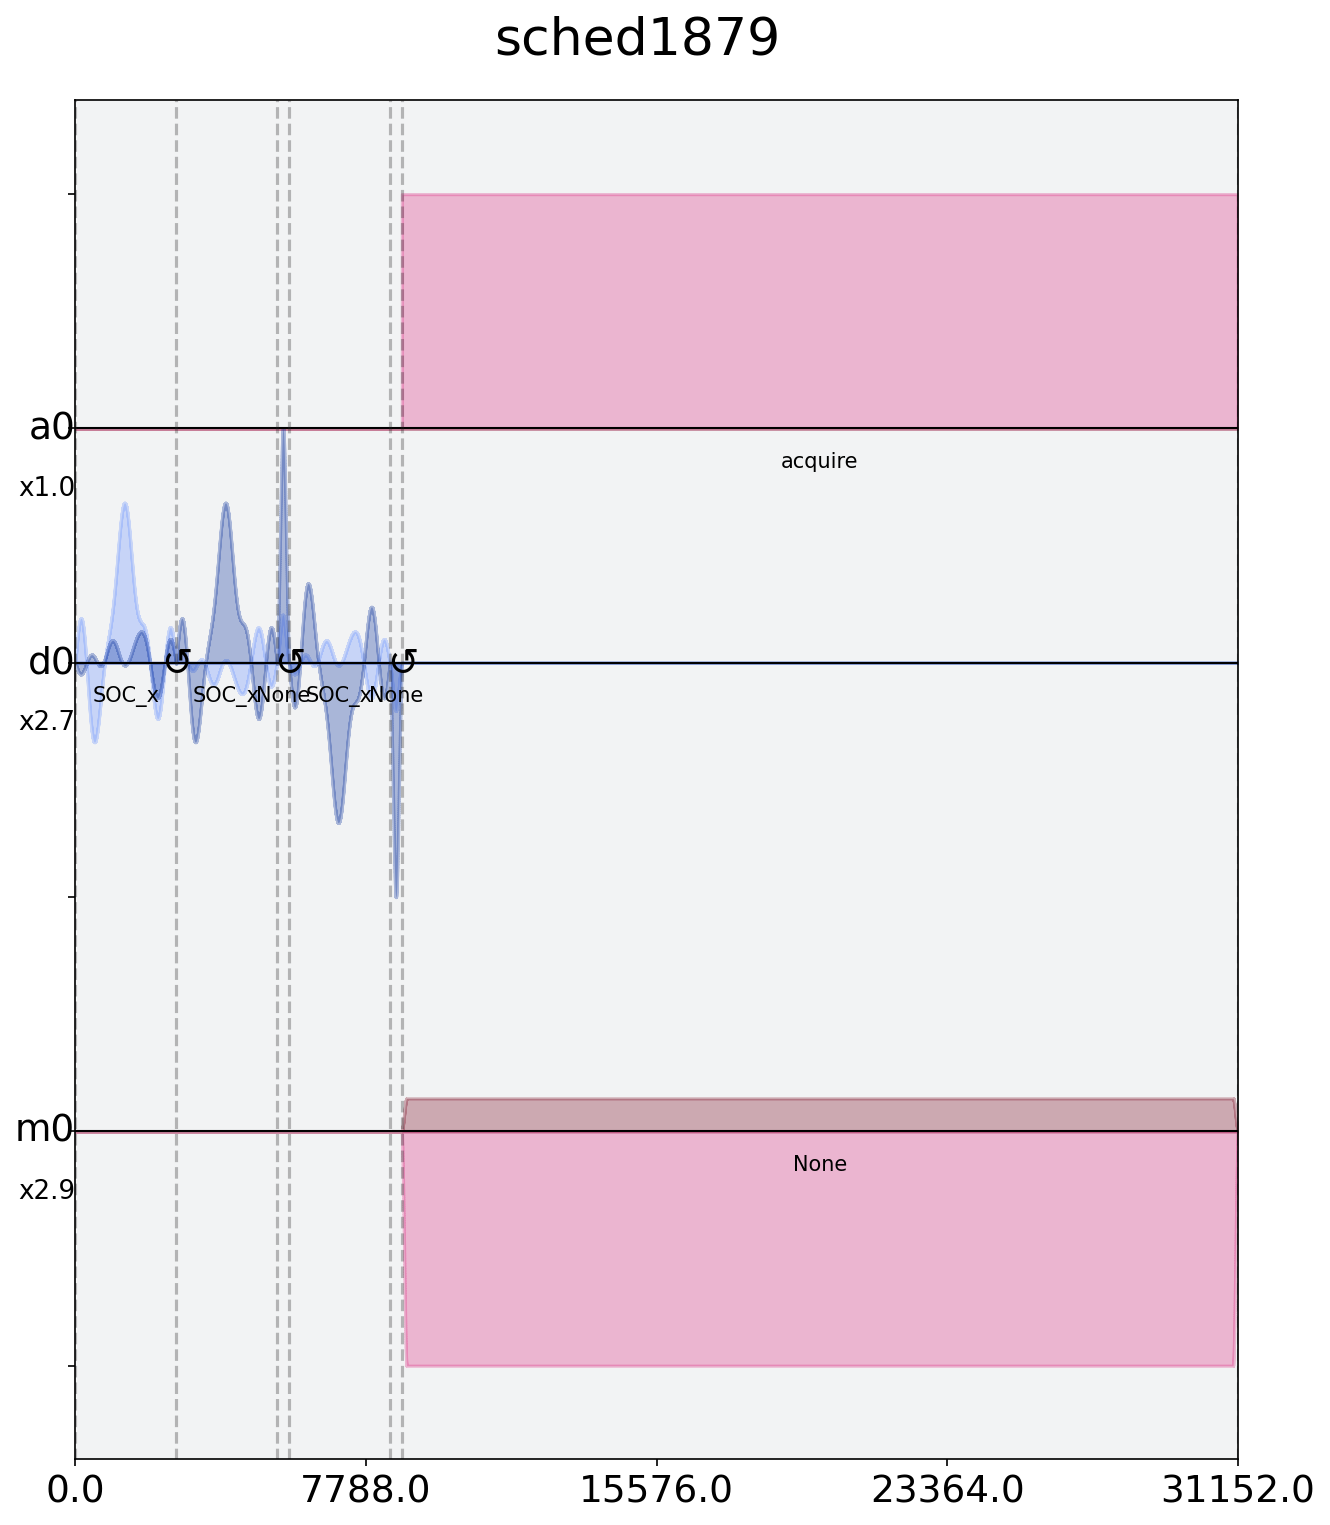

In [114]:
reference_schedules, interleaved_schedules, expected_final_results = RB_xyz_schedules(3,2,'Q','S')
#reference_schedules[0][2].draw(label = True)
interleaved_schedules[0][2].draw(label = True)

In [120]:
 def RB_experiment(m, n, base = 'Q', x_gate = 'Q', n_sequence=1,detuning = 0): #(m은 reference sequence 길이, n은 reference seqeucne 개수)
                                                                                #(n_sequence는 한번에 실행하는 sequence 개수)
            
    
    print(f'Selected {n} reference sequences with length {m}')
    reference_schedules, interleaved_schedules, expected_final_results = RB_xyz_schedules(m,n, base, x_gate)
    
    reference_fidelity_list = []
    interleaved_fidelity_list = []

    average_reference_fidelity = 0
    average_interleaved_fidelity = 0

    total_experiment_num = np.ceil(n/n_sequence)
    experiment_schedule = []
    experiment_result = []
    
    for k in range(n):        
        experiment_schedule.extend(reference_schedules[k])
        experiment_result.append(expected_final_results[k])
        if ((k+1) % n_sequence == 0):
            print(f'reference schedule {np.arange(k+2-n_sequence,k+2).tolist()}')
            fidelity_list = get_fidelity_from_xyz_schedule2(experiment_schedule, experiment_result, int(n_sequence), detuning = detuning)
            average_reference_fidelity += sum(fidelity_list)
            reference_fidelity_list.extend(fidelity_list)
            experiment_schedule = []
            experiment_result = []
        elif (k == n-1):
            print(f'reference schedule {np.arange((total_experiment_num-1) * n_sequence +1,n+1).astype(np.int64).tolist()}')
            fidelity_list = get_fidelity_from_xyz_schedule2(experiment_schedule, experiment_result, int(n - n_sequence * (total_experiment_num-1)),detuning = detuning )
            average_reference_fidelity += sum(fidelity_list)
            reference_fidelity_list.extend(fidelity_list)
            experiment_schedule = []
            experiment_result = []
       
    for k in range(n):        
        experiment_schedule.extend(interleaved_schedules[k])
        experiment_result.append(expected_final_results[k])
        if ((k+1) % n_sequence == 0):
            print(f'interleaved schedule {np.arange(k+2-n_sequence,k+2).tolist()}')
            fidelity_list = get_fidelity_from_xyz_schedule2(experiment_schedule, experiment_result,int(n_sequence), detuning = detuning)
            average_interleaved_fidelity += sum(fidelity_list)
            interleaved_fidelity_list.extend(fidelity_list)
            experiment_schedule = []
            experiment_result = []
        elif (k == n-1):
            print(f'interleaved schedule {np.arange((total_experiment_num-1) * n_sequence +1,n+1).astype(np.int64).tolist()}')
            fidelity_list = get_fidelity_from_xyz_schedule2(experiment_schedule, experiment_result, int(n - n_sequence * (total_experiment_num-1)), detuning = detuning)
            average_interleaved_fidelity += sum(fidelity_list)
            interleaved_fidelity_list.extend(fidelity_list)
            experiment_schedule = []
            experiment_result = []

    
    average_reference_fidelity = average_reference_fidelity/n
    average_interleaved_fidelity = average_interleaved_fidelity/n
    
    print(f'The average reference fidelity is {average_reference_fidelity}')
    print(f'The average interleaved fidelity is {average_interleaved_fidelity}')
   
    return average_reference_fidelity, average_interleaved_fidelity, reference_fidelity_list, interleaved_fidelity_list


### Base = 'Q', x_gate = 'S', Detuning = 0

In [121]:
ms = np.arange(1,82,2)
experiment_num_per_m = 30

average_reference_fidelity_per_m = np.zeros(len(ms))
reference_fidelity_per_m = np.zeros((len(ms), experiment_num_per_m))

average_interleaved_fidelity_per_m = np.zeros(len(ms))
interleaved_fidelity_per_m = np.zeros((len(ms), experiment_num_per_m))

In [122]:
n_sequence = 15
n = 0
average_reference_fidelity_per_m[n], average_interleaved_fidelity_per_m[n], reference_fidelity_per_m[n], interleaved_fidelity_per_m = RB_experiment(ms[n],experiment_num_per_m,base = 'Q', x_gate = 'S',n_sequence =n_sequence)
    

Selected 30 reference sequences with length 1
schdeule 1
Randomly Selected Sequence: [7] / ['zs']
Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 1 / ['x']
Recovery Gate for Interleaved sequence: 4 / ['s']
********************
schdeule 2
Randomly Selected Sequence: [15] / ['zsh']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 19 / ['zhs']
Recovery Gate for Interleaved sequence: 17 / ['xhs']
********************
schdeule 3
Randomly Selected Sequence: [18] / ['yhs']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interle

********************
schdeule 29
Randomly Selected Sequence: [18] / ['yhs']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 14 / ['ysh']
Recovery Gate for Interleaved sequence: 11 / ['zh']
********************
schdeule 30
Randomly Selected Sequence: [6] / ['ys']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 2 / ['y']
Recovery Gate for Interleaved sequence: 3 / ['z']
********************
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job has successfully run
x_result: {'0': 525, '1': 499}/   y_result: {'0': 539, '1': 485}/   z_result: 

<ipython-input-122-b99e462cc5f0>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  average_reference_fidelity_per_m[n], average_interleaved_fidelity_per_m[n], reference_fidelity_per_m[n], interleaved_fidelity_per_m = RB_experiment(ms[n],experiment_num_per_m,base = 'Q', x_gate = 'S',n_sequence =n_sequence)


In [127]:
for n in range(1,21):
    average_reference_fidelity_per_m[n], average_interleaved_fidelity_per_m[n], reference_fidelity_per_m[n], interleaved_fidelity_per_m = RB_experiment(ms[n],experiment_num_per_m,base = 'Q', x_gate = 'S',n_sequence =n_sequence)

Selected 30 reference sequences with length 3
schdeule 1
Randomly Selected Sequence: [23 14  0] / ['zshs', 'ysh', 'I']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 11 / ['zh']
Recovery Gate for Interleaved sequence: 8 / ['h']
********************
schdeule 2
Randomly Selected Sequence: [23  3 20] / ['zshs', 'z', 'shs']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 1 / ['x']
Recovery Gate for Interleaved sequence: 0 / ['I']
********************
schdeule 3
Randomly Selected Sequence: [ 1  8 15] / ['x', 'h', 'zsh']
Reference Sequence: recovery gate for 0: [1, 2, 5, 6] / 

********************
schdeule 23
Randomly Selected Sequence: [ 2 15  5] / ['y', 'zsh', 'xs']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 15 / ['zsh']
Recovery Gate for Interleaved sequence: 10 / ['yh']
********************
schdeule 24
Randomly Selected Sequence: [12 23 19] / ['sh', 'zshs', 'zhs']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 12 / ['sh']
Recovery Gate for Interleaved sequence: 10 / ['yh']
********************
schdeule 25
Randomly Selected Sequence: [14 11 15] / ['ysh', 'zh', 'zsh']
Reference Sequence: recovery gate for 0: [9, 10, 13, 14] 

Job Status: job has successfully run
x_result: {'0': 761, '1': 263}/   y_result: {'0': 546, '1': 478}/   z_result: {'0': 917, '1': 107}
fidelity: (0.8955078125+0j)
x_result: {'0': 503, '1': 521}/   y_result: {'0': 315, '1': 709}/   z_result: {'0': 936, '1': 88}
fidelity: (0.9140625+0j)
x_result: {'0': 702, '1': 322}/   y_result: {'0': 316, '1': 708}/   z_result: {'0': 129, '1': 895}
fidelity: (0.8740234375+0j)
x_result: {'0': 339, '1': 685}/   y_result: {'0': 503, '1': 521}/   z_result: {'0': 952, '1': 72}
fidelity: (0.9296875+0j)
x_result: {'0': 569, '1': 455}/   y_result: {'0': 517, '1': 507}/   z_result: {'0': 45, '1': 979}
fidelity: (0.9560546875+0j)
x_result: {'0': 678, '1': 346}/   y_result: {'0': 656, '1': 368}/   z_result: {'0': 943, '1': 81}
fidelity: (0.9208984375+0j)
x_result: {'0': 625, '1': 399}/   y_result: {'0': 657, '1': 367}/   z_result: {'0': 955, '1': 69}
fidelity: (0.9326171875+0j)
x_result: {'0': 564, '1': 460}/   y_result: {'0': 707, '1': 317}/   z_result: {'0': 9

<ipython-input-127-8525e80731fb>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  average_reference_fidelity_per_m[n], average_interleaved_fidelity_per_m[n], reference_fidelity_per_m[n], interleaved_fidelity_per_m = RB_experiment(ms[n],experiment_num_per_m,base = 'Q', x_gate = 'S',n_sequence =n_sequence)


 0
Recovery Gate for reference sequence: 5 / ['xs']
Recovery Gate for Interleaved sequence: 1 / ['x']
********************
schdeule 17
Randomly Selected Sequence: [20  4  2 21  8] / ['shs', 's', 'y', 'xshs', 'h']
Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 3 / ['z']
Recovery Gate for Interleaved sequence: 4 / ['s']
********************
schdeule 18
Randomly Selected Sequence: [20 15 13 17 20] / ['shs', 'zsh', 'xsh', 'xhs', 'shs']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [9, 10, 13, 14] /  recovery gate for 1: [8, 11, 12, 15]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 11 / ['zh']
Recovery Gate for Interleaved sequence: 9 / ['xh']
********************
schdeule 

Job Status: job has successfully run
x_result: {'0': 484, '1': 540}/   y_result: {'0': 546, '1': 478}/   z_result: {'0': 1001, '1': 23}
fidelity: (0.9775390625+0j)
x_result: {'0': 536, '1': 488}/   y_result: {'0': 516, '1': 508}/   z_result: {'0': 1009, '1': 15}
fidelity: (0.9853515625+0j)
x_result: {'0': 528, '1': 496}/   y_result: {'0': 527, '1': 497}/   z_result: {'0': 1003, '1': 21}
fidelity: (0.9794921875+0j)
x_result: {'0': 513, '1': 511}/   y_result: {'0': 476, '1': 548}/   z_result: {'0': 1009, '1': 15}
fidelity: (0.9853515625+0j)
x_result: {'0': 513, '1': 511}/   y_result: {'0': 546, '1': 478}/   z_result: {'0': 40, '1': 984}
fidelity: (0.9609375+0j)
x_result: {'0': 501, '1': 523}/   y_result: {'0': 500, '1': 524}/   z_result: {'0': 21, '1': 1003}
fidelity: (0.9794921875+0j)
x_result: {'0': 536, '1': 488}/   y_result: {'0': 529, '1': 495}/   z_result: {'0': 997, '1': 27}
fidelity: (0.9736328125+0j)
x_result: {'0': 526, '1': 498}/   y_result: {'0': 526, '1': 498}/   z_result: {

Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 18 / ['yhs']
Recovery Gate for Interleaved sequence: 16 / ['hs']
********************
schdeule 28
Randomly Selected Sequence: [17  2 23  3 18 22  7] / ['xhs', 'y', 'zshs', 'z', 'yhs', 'yshs', 'zs']
Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 7 / ['zs']
Recovery Gate for Interleaved sequence: 5 / ['xs']
********************
schdeule 29
Randomly Selected Sequence: [12  6  8 18 15 18 11] / ['sh', 'ys', 'h', 'yhs', 'zsh', 'yhs', 'zh']
Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5,

Randomly Selected Sequence: [11 19 11  1  4  1 16  2 13] / ['zh', 'zhs', 'zh', 'x', 's', 'x', 'hs', 'y', 'xsh']
Reference Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
Interleaved Sequence: recovery gate for 0: [8, 11, 12, 15] /  recovery gate for 1: [9, 10, 13, 14]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 9 / ['xh']
Recovery Gate for Interleaved sequence: 13 / ['xsh']
********************
schdeule 13
Randomly Selected Sequence: [21 16  8 23  4  1  2 22  0] / ['xshs', 'hs', 'h', 'zshs', 's', 'x', 'y', 'yshs', 'I']
Reference Sequence: recovery gate for 0: [0, 3, 4, 7] /  recovery gate for 1: [1, 2, 5, 6]
Interleaved Sequence: recovery gate for 0: [1, 2, 5, 6] /  recovery gate for 1: [0, 3, 4, 7]
The Expected Final_Result is 0
Recovery Gate for reference sequence: 4 / ['s']
Recovery Gate for Interleaved sequence: 6 / ['ys']
********************
schdeule 14
Randomly Selected Sequence: [18 20  0 13  0 11 11  7  5] / ['yhs

Job Status: job has successfully run
x_result: {'0': 534, '1': 490}/   y_result: {'0': 535, '1': 489}/   z_result: {'0': 35, '1': 989}
fidelity: (0.9658203125+0j)
x_result: {'0': 547, '1': 477}/   y_result: {'0': 533, '1': 491}/   z_result: {'0': 1006, '1': 18}
fidelity: (0.982421875+0j)
x_result: {'0': 499, '1': 525}/   y_result: {'0': 539, '1': 485}/   z_result: {'0': 32, '1': 992}
fidelity: (0.96875+0j)
x_result: {'0': 506, '1': 518}/   y_result: {'0': 508, '1': 516}/   z_result: {'0': 41, '1': 983}
fidelity: (0.9599609375+0j)
x_result: {'0': 513, '1': 511}/   y_result: {'0': 520, '1': 504}/   z_result: {'0': 29, '1': 995}
fidelity: (0.9716796875+0j)
x_result: {'0': 523, '1': 501}/   y_result: {'0': 551, '1': 473}/   z_result: {'0': 1005, '1': 19}
fidelity: (0.9814453125+0j)
x_result: {'0': 525, '1': 499}/   y_result: {'0': 539, '1': 485}/   z_result: {'0': 1010, '1': 14}
fidelity: (0.986328125+0j)
x_result: {'0': 524, '1': 500}/   y_result: {'0': 516, '1': 508}/   z_result: {'0': 3

Randomly Selected Sequence: [15 23 16  4  4 23 19  8  9 15  5] / ['zsh', 'zshs', 'hs', 's', 's', 'zshs', 'zhs', 'h', 'xh', 'zsh', 'xs']
Reference Sequence: recovery gate for 0: [16, 19, 20, 23] /  recovery gate for 1: [17, 18, 21, 22]
Interleaved Sequence: recovery gate for 0: [17, 18, 21, 22] /  recovery gate for 1: [16, 19, 20, 23]
The Expected Final_Result is 1
Recovery Gate for reference sequence: 21 / ['xshs']
Recovery Gate for Interleaved sequence: 16 / ['hs']
********************
reference schedule [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Job Status: job is actively running

KeyboardInterrupt: 

In [ ]:
n_sequence = 10
for n in range(21,41):
    average_reference_fidelity_per_m[n], average_interleaved_fidelity_per_m[n], reference_fidelity_per_m[n], interleaved_fidelity_per_m = RB_experiment(ms[n],experiment_num_per_m,base = 'Q', x_gate = 'S',n_sequence =n_sequence)